<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/Crank_em_vull_matar_Nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bueno toca Crank-Nicolson  \
Si fas com derivades numèriques i reordenes queda:
$T_{i+1}^n (1+2\gamma)-\gamma·T_{i+1}^{n+1}-\gamma · T_{i+1}^{n-1} = T_i^n + \gamma · T_i^{n+1} + \gamma ·T_i
^{n-1} + Δt$\
que es pot escriure com un sistema de matrius to jodido pero bueno tenim llibreries\
Tenim dues matrius tridiagonals.\
 La de l'esquerre, matriu A, te per offdiagonal $-\gamma$ i per diagonal $(1+2\gamma)$ i multiplica un vector de les T a temps i+1\
 La de la dreta, matriu B, te per offdiagonal $\gamma$ i per diagonal $(1-2\gamma)$ i multiplica un vector de les T a temps i i li suma $Δt$\
 Necessitem puto invertir la matriu de l'esquerre, multiplicar tot a la dreta per l'inversa i tenim el vector d'incognites aïllat amb coses que coneixem (vamos que tenim el sistema resolt)

In [3]:
import numpy as np
from scipy.linalg import toeplitz
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.patches as pt

#definim matriu A
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40

#vamo a calcular:
alpha_var= kappa/(C_v*rho) #es la difusivitat

N= 101   # Mallat espaial, nombre de punts que tenim
x_0= 0.02 #per la cara, pq x_f ha de ser 0.02 (2 cm) i ha d'estar normalitzat així que ha de valer 1 JA SABEM PER QUÈ ENS HEM D'INVENTAR x_0
x_f= 0.02/x_0 #normalitzar, ja que \tilde{x}=x/x_0
x_i= 0
t_i= 0
t_0= x_0**2/alpha_var #\tilde{t}=t/t_0
t_f= 0.025 #ja està normalitzat, ho diu l'enunciat

P_ext= volts**2*sigma/(2*(x_0)**2) #calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 #KELVIN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("T_0=",T_0,"k")
T_init= 309.65/T_0   #CREC QUE HA D'ESTAR EN KELVIN PER LES UNITATS YOQUESE
print("T_init (JA NORMALITZADA)=",T_init,"k")

dx=x_f/(N-1)
dt_1= dx**2
dt_2= 0.5*dx**2
def CN(N, T_i, t_f, dt, dx):

  gamma= dt/(2*dx**2)

  dt_vect=np.ones((N-2,1))*dt
  dt_vect[0]= 2*gamma*T_i + dt
  dt_vect[-1]=2*gamma*T_i + dt

  T_i_vect = np.ones((N-2,1))*T_i
  fila1_A= (N-2)*[0]
  fila1_A [0]= 1+2*gamma
  fila1_A [1]= -gamma
  col_A = (N-2)*[0]
  col_A [1]= -gamma
  A = toeplitz(fila1_A,col_A)

  print(A)

  fila1_B= (N-2)*[0]
  fila1_B [0]= 1-2*gamma
  fila1_B [1]= gamma
  col_B = (N-2)*[0]
  col_B [1]= gamma
  B = toeplitz(fila1_B,col_B)

  print(B)
  Ainv=inv(A)
  t_i=0
  while t_i<t_f:
    T_i_vect= np.matmul(Ainv,np.matmul(B,T_i_vect))+np.matmul(Ainv,dt_vect)
    t_i = t_i +dt

  T_i_vect = T_i_vect*T_0-273.15
  T_i_vect =np.append(T_i_vect,[36.5])
  T_i_vect =np.append([36.5],T_i_vect)
  return T_i_vect

#pel primer cas tenim que delta t = delta x **2 --> gamma1 = 1/2
#pel segon tenim que delta t = 1/2 delta x**2 --> gamma2=1/4

T1=CN(101,T_init,t_f,dt_1,dx)
T2=CN(101,T_init,t_f,dt_2,dx)

print (T1 +273.15)

T_0= 674.2857142857143 k
T_init (JA NORMALITZADA)= 0.4592266949152542 k
[[ 2.  -0.5  0.  ...  0.   0.   0. ]
 [-0.5  2.  -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  2.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.  -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  2.  -0.5]
 [ 0.   0.   0.  ...  0.  -0.5  2. ]]
[[0.  0.5 0.  ... 0.  0.  0. ]
 [0.5 0.  0.5 ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.5 0.  0.5]
 [0.  0.  0.  ... 0.  0.5 0. ]]
[[ 1.5  -0.25  0.   ...  0.    0.    0.  ]
 [-0.25  1.5  -0.25 ...  0.    0.    0.  ]
 [ 0.   -0.25  1.5  ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.5  -0.25  0.  ]
 [ 0.    0.    0.   ... -0.25  1.5  -0.25]
 [ 0.    0.    0.   ...  0.   -0.25  1.5 ]]
[[0.5  0.25 0.   ... 0.   0.   0.  ]
 [0.25 0.5  0.25 ... 0.   0.   0.  ]
 [0.   0.25 0.5  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.5  0.25 0.  ]
 [0.   0.   0.   ... 0.25 0.5  0.25]
 [0.   0.   0.   ... 0.   0.25 0.5 ]]
[309.65       31

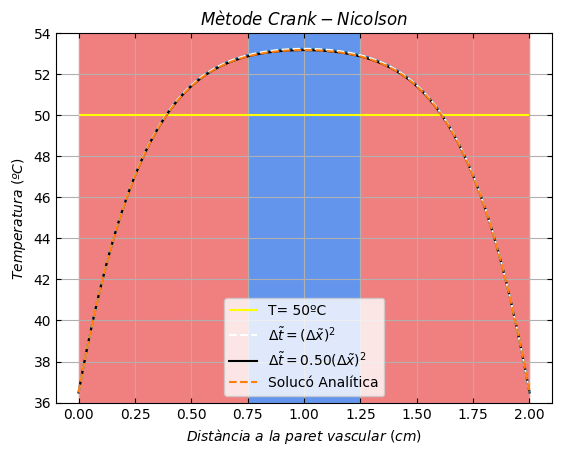

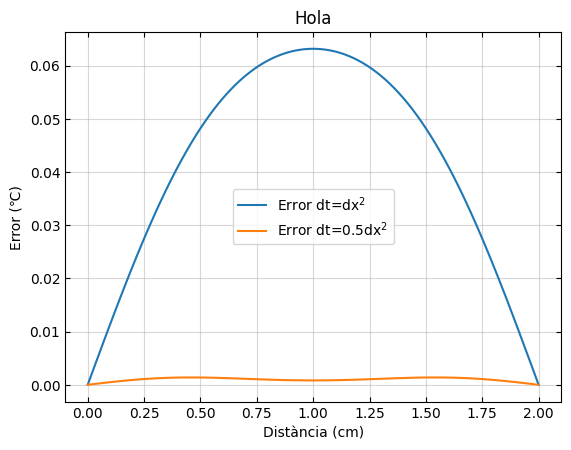

In [4]:

fig, ax= plt.subplots()

x=np.linspace(0,2,101)
ax.plot(x,T1)

#vale pillem només l'array per no executar again
T_real_analitica =[36.5, 37.66969107552376, 38.774358434195335, 39.81640154529612, 40.79821064375386, 41.72216161151641, 42.590611364820006, 43.40589332815745, 44.17031304193472, 44.88614393046629, 45.55562325343692, 46.180948261775995, 46.76427257678938, 47.307702809179034, 47.813295432258144, 48.28305392123838, 48.71892616796447, 49.12280217792255, 49.496512053786034, 49.84182426721014, 50.16044421807828, 50.45401307796095, 50.72410691220182, 50.97223607281086, 51.19984485225365, 51.40831138628192, 51.59894779218382, 51.77300052724229, 51.931650950796836, 52.0760160721066, 52.207149465221676, 52.32604233127694, 52.433624688043835, 52.53076666618608, 52.6182798914777, 52.6969189322416, 52.76738279144132, 52.83031642321015, 52.886312254103814, 52.93591169002019, 52.979606590514436, 53.01784069315329, 53.05101097157308, 53.07946891202897, 53.1035216944332, 53.12343326516634, 53.139425290298334, 53.15167797926523, 53.16033077050395, 53.165482872043015, 53.16719365156882, 53.165482872043015, 53.16033077050395, 53.15167797926523, 53.139425290298334, 53.12343326516634, 53.1035216944332, 53.07946891202897, 53.05101097157308, 53.01784069315329, 52.979606590514436, 52.93591169002019, 52.886312254103814, 52.83031642321015, 52.76738279144132, 52.6969189322416, 52.6182798914777, 52.53076666618608, 52.433624688043835, 52.32604233127694, 52.207149465221676, 52.0760160721066, 51.931650950796836, 51.77300052724229, 51.59894779218382, 51.40831138628192, 51.19984485225365, 50.97223607281086, 50.72410691220182, 50.45401307796095, 50.16044421807828, 49.84182426721014, 49.496512053786034, 49.12280217792255, 48.718926167964526, 48.28305392123838, 47.813295432258144, 47.307702809179034, 46.76427257678938, 46.180948261775995, 45.55562325343692, 44.88614393046629, 44.17031304193472, 43.40589332815745, 42.590611364820006, 41.72216161151641, 40.79821064375386, 39.81640154529612, 38.774358434195335, 37.66969107552376, 36.5]

lim_inf_y= float(np.floor(min(T1)))
altura= float(np.floor(max(T1)+1)-np.floor(min(T1)))

rectangle_cor= pt.Rectangle((0.75, lim_inf_y), 0.5, altura, color="cornflowerblue", alpha=1)
rectangle_esq= pt.Rectangle((0, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)
rectangle_dre= pt.Rectangle((1.25, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

plt.title(r"$Mètode\ Crank-Nicolson$")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Temperatura\ (ºC)$")

ax.tick_params(direction='in', top=True, right=True)
plt.ylim(lim_inf_y, np.floor(max(T1)+1))
plt.hlines(50, 0, 2, color="yellow", label="T= 50ºC")

plt.plot(x, T1, color="white", label=r"$\Delta \tilde{t}= (\Delta \tilde{x})^2$", linestyle="--",zorder= 5)
plt.plot(x, T2, color="k", label=r"$\Delta \tilde{t}= 0.50(\Delta \tilde{x})^2$")
plt.plot(x, T_real_analitica, "--", label="Solucó Analítica",zorder=8)
plt.legend()
plt.grid("equal")
plt.show()

plt.figure()
plt.plot(x, np.abs(T1-T_real_analitica), label="Error dt=dx$^2$")
plt.plot(x, np.abs(T_real_analitica - T2), label="Error dt=0.5dx$^2$")
plt.xlabel("Distància (cm)")
plt.ylabel("Error (℃)")
plt.grid(True, alpha=0.5)
plt.title("Hola")
plt.legend()
plt.tick_params(direction='in', top=True, right=True)
plt.show()